In [1]:
%matplotlib notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import IPython
import os

from load_data import *
from transformation import *
import cv2
from pr2_utils import *
from map_utils import *
from motion_utils import *
from particle import *

In [8]:
dataset = 20
with np.load("../data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images, (2407,)
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images, (2289,)

array([1.29844528e+09, 1.29844528e+09, 1.29844528e+09, ...,
       1.29844540e+09, 1.29844540e+09, 1.29844540e+09])

In [11]:
rgb_stamps

array([1.29844528e+09, 1.29844528e+09, 1.29844528e+09, ...,
       1.29844540e+09, 1.29844540e+09, 1.29844540e+09])

In [17]:
import glob
root = f"../data/dataRGBD/Disparity{dataset}/"
fnames = sorted(glob.glob(os.path.join(root, '*')))

In [ ]:
fnames

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

disp_path = "../data/dataRGBD/Disparity20/"
rgb_path = "../data/dataRGBD/RGB20/"

def normalize(img):
   max_ = img.max()
   min_ = img.min()
   return (img - min_)/(max_-min_)


# load RGBD image
imd = cv2.imread(disp_path+'disparity20_1.png',cv2.IMREAD_UNCHANGED) # (480 x 640)
imc = cv2.imread(rgb_path+'rgb20_1.png')[...,::-1] # (480 x 640 x 3)

print(imd.shape)
print(imc.shape)

# convert from disparity from uint16 to double
disparity = imd.astype(np.float32)

# get depth
dd = (-0.00304 * disparity + 3.31)
z = 1.03 / dd

# calculate u and v coordinates 
v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
#u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))

# get 3D coordinates 
fx = 585.05108211
fy = 585.05108211
cx = 315.83800193
cy = 242.94140713
x = (u-cx) / fx * z
y = (v-cy) / fy * z

# calculate the location of each pixel in the RGB image
rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
rgbv = np.round((v * 526.37 + 16662.0)/fy)
valid = (rgbu>= 0)&(rgbu < disparity.shape[1])&(rgbv>=0)&(rgbv<disparity.shape[0])

# display valid RGB pixels
fig = plt.figure(figsize=(10, 13.3))
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot(projection='3d')
ax.scatter(z[valid],-x[valid],-y[valid],c=imc[rgbv[valid].astype(int),rgbu[valid].astype(int)]/255.0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=0, azim=180)
plt.show()

# display disparity image
plt.imshow(normalize(imd), cmap='gray')
plt.show()

In [38]:
c = imc[rgbv[valid].astype(int),rgbu[valid].astype(int)]
c.shape

(303305, 3)

In [43]:
rgbv.shape

(480, 640)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

dis_fn = 'disparity20_1.png'
rgb_fn = 'rgb20_1.png'
disp_path = "../data/dataRGBD/Disparity20/" + dis_fn
rgb_path = "../data/dataRGBD/RGB20/" + rgb_fn

def normalize(img):
   max_ = img.max()
   min_ = img.min()
   return (img - min_)/(max_-min_)

def getRGB(disp_path, rgb_path):
   # load RGBD image
   imd = cv2.imread(disp_path, cv2.IMREAD_UNCHANGED) # (480 x 640)
   imc = cv2.imread(rgb_path)[...,::-1] # (480 x 640 x 3)

   # convert from disparity from uint16 to double
   disparity = imd.astype(np.float32)

   # get depth
   dd = (-0.00304 * disparity + 3.31)
   z = 1.03 / dd

   # calculate u and v coordinates 
   v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
   #u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))

   # get 3D coordinates 
   fx = 585.05108211
   fy = 585.05108211
   cx = 315.83800193
   cy = 242.94140713
   x = (u-cx) / fx * z
   y = (v-cy) / fy * z

   # calculate the location of each pixel in the RGB image
   rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
   rgbv = np.round((v * 526.37 + 16662.0)/fy)
   valid = (rgbu>= 0)&(rgbu < disparity.shape[1])&(rgbv>=0)&(rgbv<disparity.shape[0])

   # coordinates, rgb color
   return z[valid],x[valid],y[valid], imc[rgbv[valid].astype(int),rgbu[valid].astype(int)]/255.0

In [99]:
def getOpital(x,y,z):
    a = np.vstack((x,y))
    a = np.vstack((a, np.ones(x.shape[0])))
    # rgbi, rgbj, 1
    b = np.vstack((z,z))
    b = np.vstack((b,z))
    c = a * b

    K = np.array([[585.05, 0, 242.94],
              [0, 585.05, 315.84],
              [0, 0, 1]])
    K_inv = np.linalg.inv(K)
    return np.matmul(K_inv, c)

In [135]:
def opticalToWorldCoordinate(optical_point, pose):
    # create points transformation matrix
    T_opt = np.vstack([optical_point, np.ones((optical_point.shape[1]))])

        # use transform tree
    T = Transform(**pose)

        # transform laser points to world frame
    optical_point_w = T.chain('wTb', 'bTc', 'cTo') @ T_opt

        # get the x-y-z coordinates
    optical_point_w = optical_point_w[:3,:].T

    return optical_point_w[:,:2]

In [123]:
z,x,y,rgb = getRGB(disp_path, rgb_path)
opti = getOpital(x,y,z)

In [136]:
pose = { 'x': 0.0, 'y': 0.0, 'theta': 0.0 }
opti_w = opticalToWorldCoordinate(opti, pose)

In [137]:
opti_w.shape

(303305, 2)

In [138]:
rgb.shape

(303305, 3)

In [139]:
# plot map with first laser scan
pose = { 'x': 0.0, 'y': 0.0, 'theta': 0.0 }
xlim = (-30,30)
ylim = (-30,30)
Map = OccupancyMap(xlim=xlim, ylim=ylim, res=0.2)

In [140]:
Map.update_texture(opti_w, rgb)

Plot...


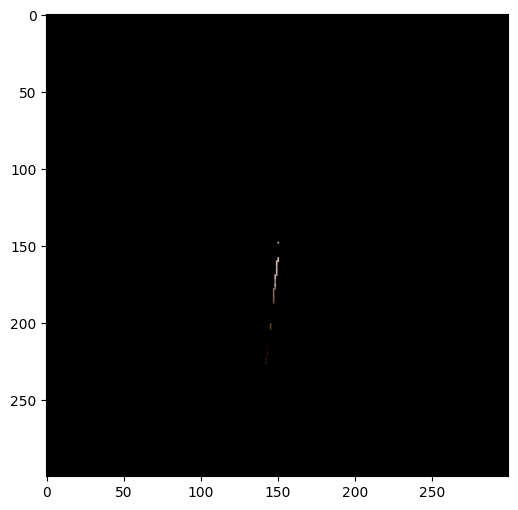

In [145]:
Map.plot_texture()